# Actor-Critic 算法实现实验

## 导入依赖

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

## 定义Actor-Critic网络

- Actor负责输出策略（在动作空间中的概率分布）
- Critic负责评估状态的价值
- 使用简单的全连接神经网络作为Actor和Critic网络

    input_dim是输入的维度，即环境的观测空间维度，output_dim是输出的维度，即动作空间的维度，hidden_dim是隐藏层的维度，即神经网络的中间层维度。
    forward方法中定义了神经网络的前向传播过程，即输入数据经过隐藏层得到激活后，分别输出Actor的logits和Critic的状态价值

In [2]:
class ActorCritic(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_actor = nn.Linear(hidden_dim, output_dim)
        self.fc_critic = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        logits = self.fc_actor(x)
        values = self.fc_critic(x)
        return logits, values

## 定义Actor-Critic算法的训练过程

In [3]:
def train_actor_critic(env_name, gamma, seed, num_episodes=5000):
    # 设置随机种子
    torch.manual_seed(seed)
    env = gym.make(env_name)
    env.seed(seed)

    # 获取环境相关信息
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    # 初始化Actor-Critic网络
    hidden_dim = 128
    model = ActorCritic(input_dim, output_dim, hidden_dim)

    # 定义优化器
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # 训练参数
    max_steps = 1000
    rewards = []

    # 训练循环
    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0

        # 生成一个episode
        for step in range(max_steps):
            # 选择动作
            logits, value = model(torch.FloatTensor(state))
            dist = Categorical(logits=logits)
            action = dist.sample()
            next_state, reward, done, _ = env.step(action.item())

            # 计算TD误差
            td_target = reward + gamma * model(torch.FloatTensor(next_state))[1] * (1 - done)
            td_error = td_target - value

            # 计算Actor和Critic的损失
            actor_loss = -dist.log_prob(action) * td_error.detach()
            critic_loss = td_error.pow(2)

            # 总损失
            total_loss = actor_loss + critic_loss

            # 反向传播更新网络参数
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # 更新状态和累计奖励
            state = next_state
            episode_reward += reward

            if done:
                break

        rewards.append(episode_reward)

        # 打印训练进度
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}")

    env.close()
    return rewards


## 实现调参实验

In [4]:
# 设置环境名称
env_name = 'CartPole-v0'

# 设置不同的折扣因子
gammas = [0.95, 0.5]

# 设置随机种子数量
num_seeds = 5

# 训练轮数
num_episodes = 5000  

# 记录不同折扣因子下的训练结果
all_rewards = []

# 循环不同折扣因子
for gamma in gammas:
    print(f"Gamma: {gamma}")
    gamma_rewards = []

    # 循环不同随机种子
    for seed in range(num_seeds):
        rewards = train_actor_critic(env_name, gamma, seed, num_episodes)  # 传入较少的轮数
        gamma_rewards.append(rewards)  # 将每集的奖励序列添加到gamma_rewards
        print(f"Seed: {seed}, Total Rewards: {sum(rewards)}")

    # 计算平均奖励
    avg_rewards = sum(sum(r) for r in gamma_rewards) / num_seeds
    all_rewards.append(gamma_rewards)
    print(f"Gamma: {gamma}, Average Rewards: {avg_rewards}")
    print(f"Gamma: {gamma}, Rewards for all seeds: {gamma_rewards}")
    
print(f"All rewards: {all_rewards}")

Gamma: 0.95
Episode 100/5000, Reward: 41.0
Episode 200/5000, Reward: 25.0
Episode 300/5000, Reward: 176.0
Episode 400/5000, Reward: 104.0
Episode 500/5000, Reward: 14.0
Episode 600/5000, Reward: 72.0
Episode 700/5000, Reward: 126.0
Episode 800/5000, Reward: 200.0
Episode 900/5000, Reward: 200.0
Episode 1000/5000, Reward: 200.0
Episode 1100/5000, Reward: 26.0
Episode 1200/5000, Reward: 200.0
Episode 1300/5000, Reward: 64.0
Episode 1400/5000, Reward: 200.0
Episode 1500/5000, Reward: 48.0
Episode 1600/5000, Reward: 200.0
Episode 1700/5000, Reward: 132.0
Episode 1800/5000, Reward: 115.0
Episode 1900/5000, Reward: 77.0
Episode 2000/5000, Reward: 200.0
Episode 2100/5000, Reward: 200.0
Episode 2200/5000, Reward: 71.0
Episode 2300/5000, Reward: 155.0
Episode 2400/5000, Reward: 76.0
Episode 2500/5000, Reward: 122.0
Episode 2600/5000, Reward: 135.0
Episode 2700/5000, Reward: 160.0
Episode 2800/5000, Reward: 77.0
Episode 2900/5000, Reward: 76.0
Episode 3000/5000, Reward: 65.0
Episode 3100/5000, R

Episode 100/5000, Reward: 9.0
Episode 200/5000, Reward: 9.0
Episode 300/5000, Reward: 9.0
Episode 400/5000, Reward: 10.0
Episode 500/5000, Reward: 14.0
Episode 600/5000, Reward: 10.0
Episode 700/5000, Reward: 9.0
Episode 800/5000, Reward: 34.0
Episode 900/5000, Reward: 58.0
Episode 1000/5000, Reward: 135.0
Episode 1100/5000, Reward: 79.0
Episode 1200/5000, Reward: 39.0
Episode 1300/5000, Reward: 72.0
Episode 1400/5000, Reward: 48.0
Episode 1500/5000, Reward: 36.0
Episode 1600/5000, Reward: 22.0
Episode 1700/5000, Reward: 29.0
Episode 1800/5000, Reward: 16.0
Episode 1900/5000, Reward: 27.0
Episode 2000/5000, Reward: 30.0
Episode 2100/5000, Reward: 20.0
Episode 2200/5000, Reward: 44.0
Episode 2300/5000, Reward: 27.0
Episode 2400/5000, Reward: 23.0
Episode 2500/5000, Reward: 36.0
Episode 2600/5000, Reward: 25.0
Episode 2700/5000, Reward: 28.0
Episode 2800/5000, Reward: 38.0
Episode 2900/5000, Reward: 42.0
Episode 3000/5000, Reward: 48.0
Episode 3100/5000, Reward: 54.0
Episode 3200/5000, R

## 绘制曲线和计算平均值及方差

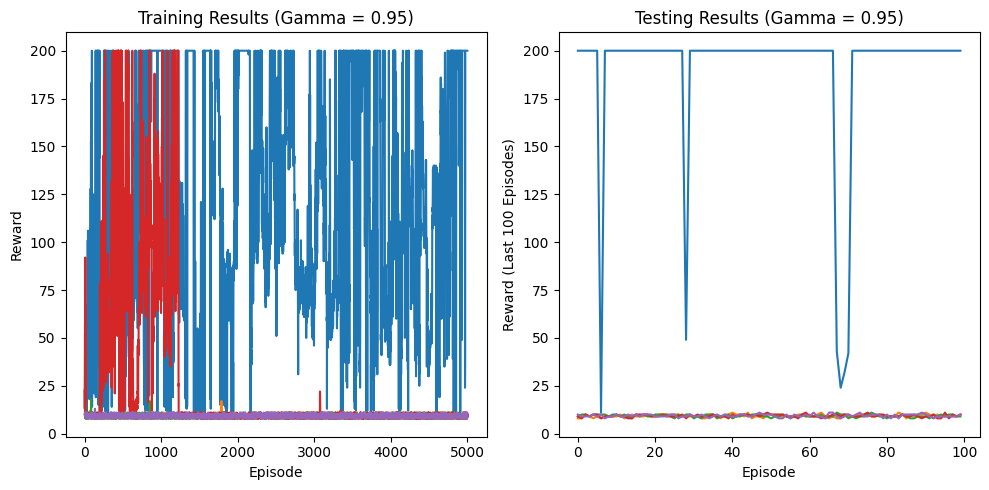

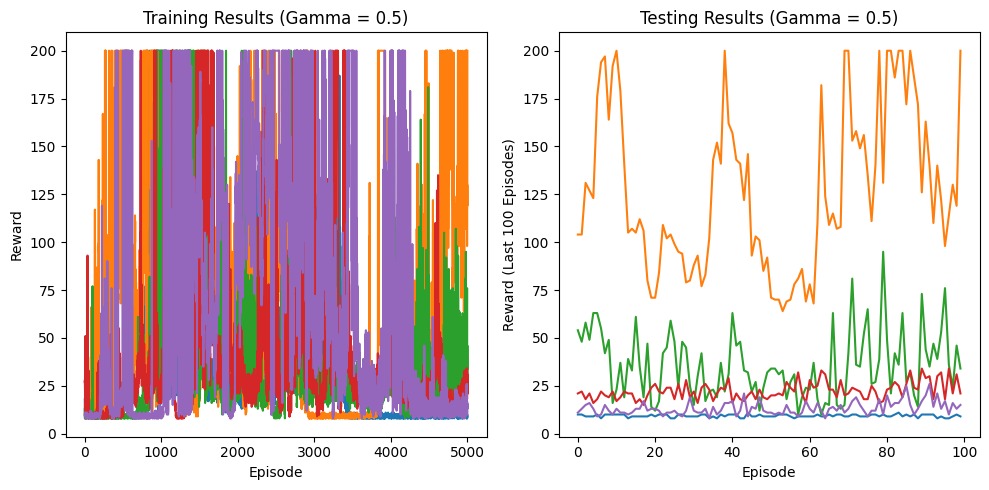

In [5]:
import matplotlib.pyplot as plt

# 绘制训练和测试结果的曲线
for i, gamma_rewards in enumerate(all_rewards):
    gamma = gammas[i]
    plt.figure(figsize=(10, 5))
    
    # 绘制训练结果
    plt.subplot(1, 2, 1)
    plt.title(f"Training Results (Gamma = {gamma})")
    for rewards in gamma_rewards:
        plt.plot(rewards)  # 绘制每一集的奖励曲线
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    
    # 绘制测试结果（最近100集的奖励）
    plt.subplot(1, 2, 2)
    plt.title(f"Testing Results (Gamma = {gamma})")
    for rewards in gamma_rewards:
        plt.plot(rewards[-100:])  # 绘制最近100集的奖励曲线
    plt.xlabel('Episode')
    plt.ylabel('Reward (Last 100 Episodes)')
    
    plt.tight_layout()
    plt.show()



In [6]:
# 计算每个算法的平均值和方差
for i, gamma_rewards in enumerate(all_rewards):
    gamma = gammas[i]
    print(f"Gamma: {gamma}")
    all_rewards_np = np.array(gamma_rewards)
    mean_rewards = np.mean(all_rewards_np, axis=0)
    max_reward = np.max(mean_rewards)
    mean_reward = np.mean(mean_rewards)
    reward_variance = np.var(mean_rewards)
    print(f"Max Reward: {max_reward}, Mean Reward: {mean_reward}, Variance: {reward_variance}")

Gamma: 0.95
Max Reward: 86.0, Mean Reward: 35.683119999999995, Variance: 240.4420830656
Gamma: 0.5
Max Reward: 146.2, Mean Reward: 49.9976, Variance: 652.18429824
